# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [29]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [30]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [32]:
# How many samples do we have?
len(df)

3155

In [33]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [34]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


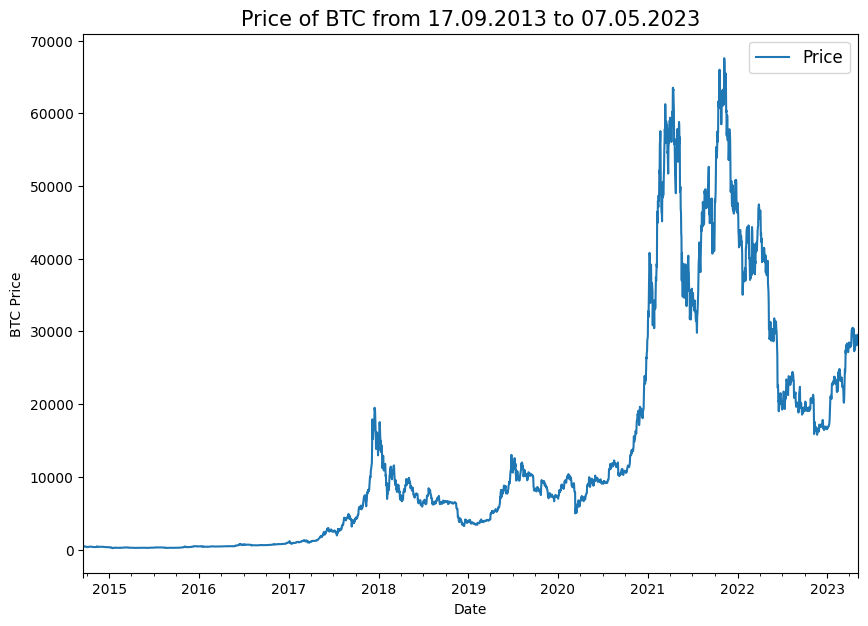

In [35]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [36]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

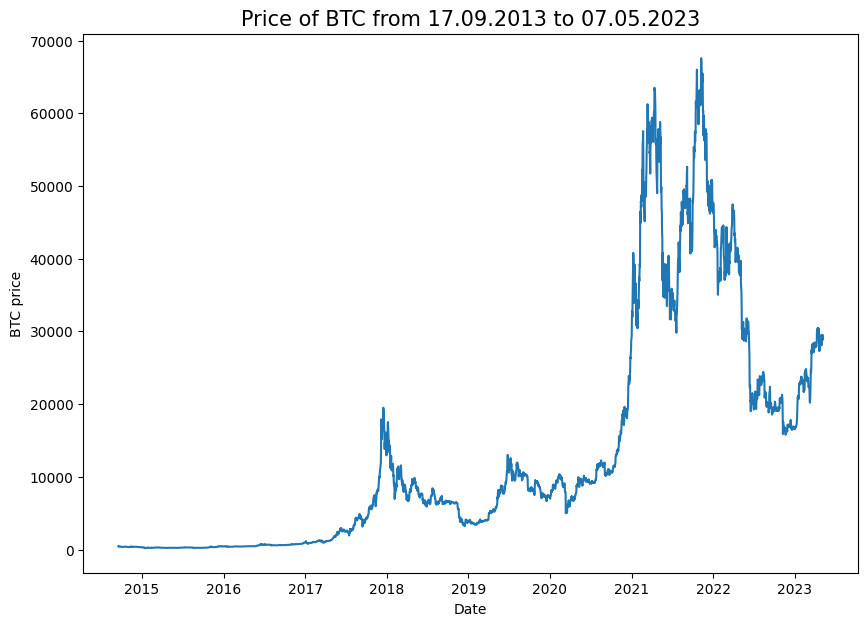

In [37]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train adn test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [38]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [39]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

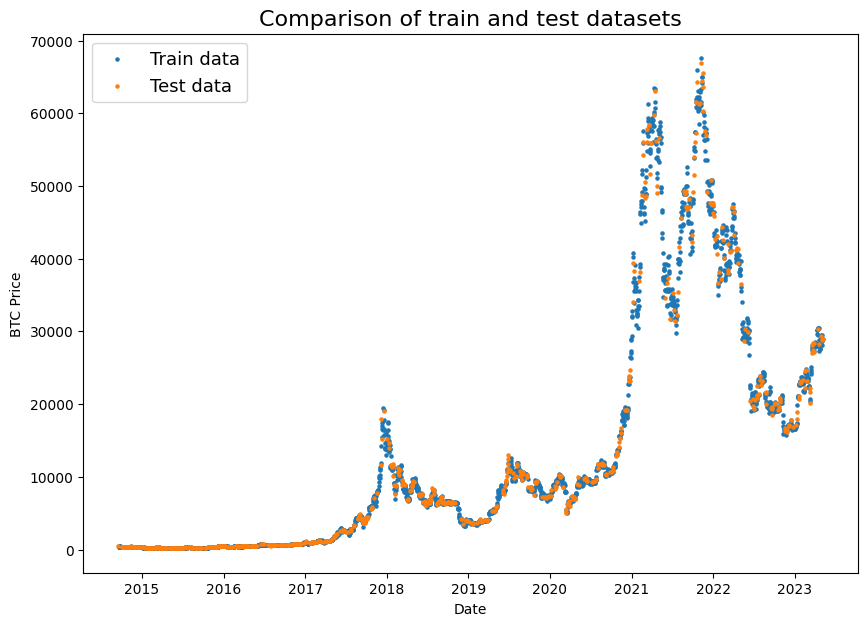

In [40]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [41]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

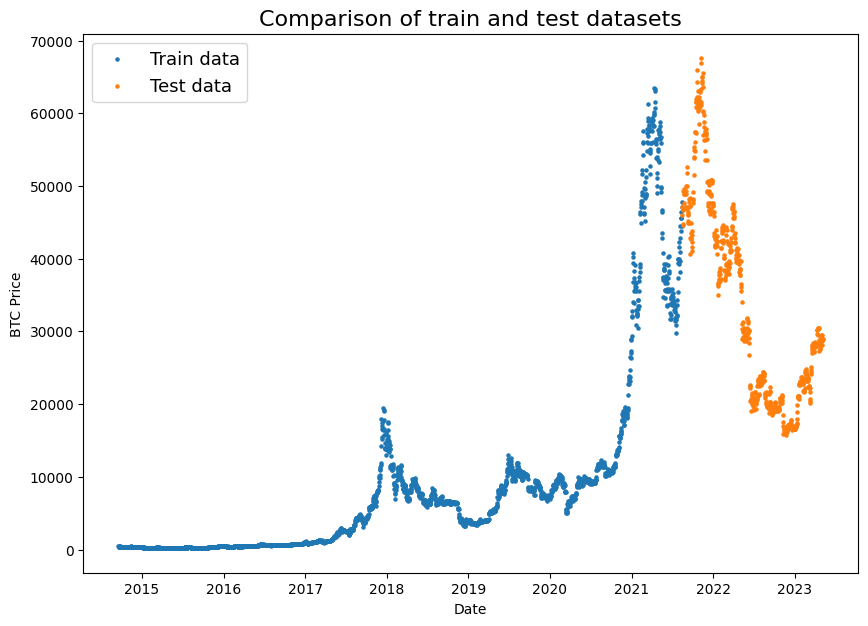

In [42]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [43]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

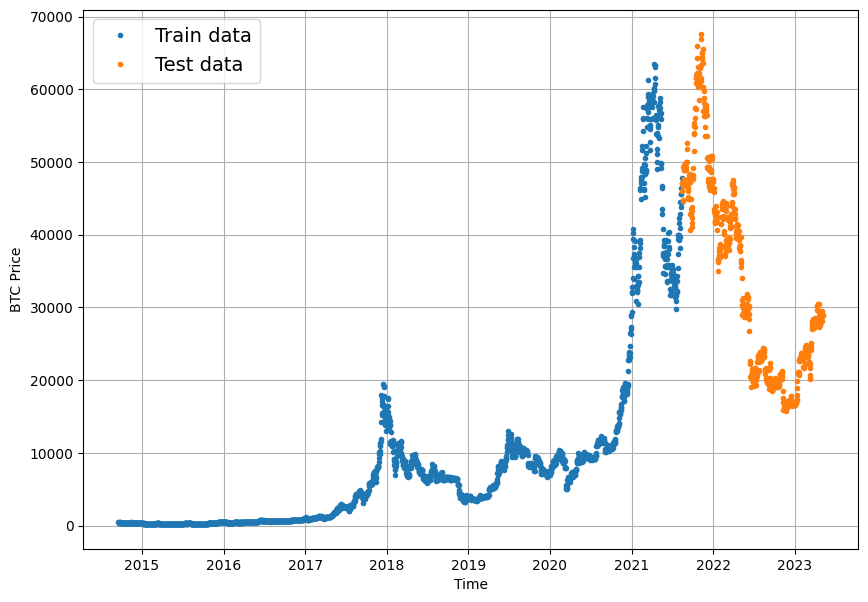

In [44]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [45]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

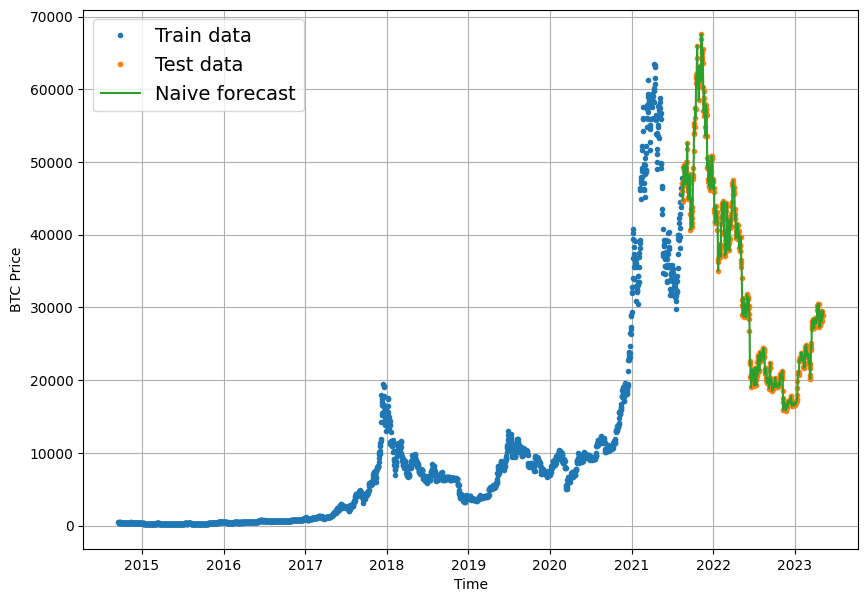

In [46]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

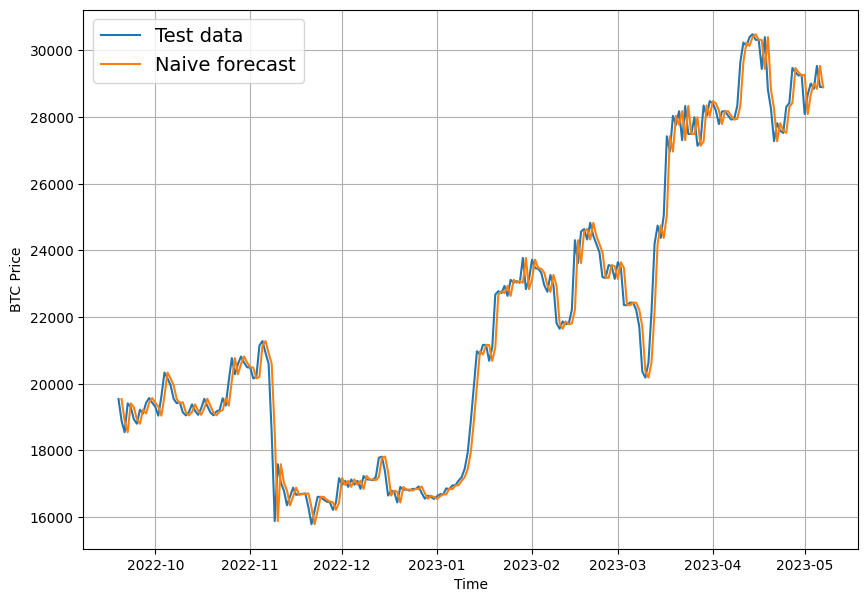

In [47]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**